# Финальный проект 


Курбет И.

Рассмотрим задачу многоклассовой классификации изображений на примере задачи соревнования на платформе kaggle: Соревнование Humpback Whale Identification. В соревонвании предлагалось реализовать классификацию китов по изображениям их хвостов.
Решать задачу будем с помощью нейронных сетей.
Поставим перед собой цель рассмотреть влияние различных техник на точность сети 
 - Аугментация данных
 - Сжатие модели - model pruning, удаление избыточных частей сети
 - Knowledge distillation
 - Снижение размера переменных
 будем считать подход применимым при неуменьшении или незначительном уменьшении точности итоговой  модели.
 
 Задачами в работе или этапами- будут 
 1. EDA входных данных
 2. Построение базовой модели
 3. Обучение с аугментацией данных 
 4. Сжатие модели , обучение 
 5. Применение Knowledge distillation
 6. Снижение размера переменных

Ниже реализованы последовательно определенные нами задачи.

1. Загружаем библиотеки

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import os
import seaborn as sns
from tqdm import tqdm


In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow
import cv2
plt.rcParams['figure.figsize'] = [12, 10]
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LeakyReLU , ReLU 
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D ,Flatten ,RepeatVector ,Reshape
from tensorflow.keras.layers import Activation, BatchNormalization, Flatten , Dropout ,MaxPool2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import  ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import top_k_categorical_accuracy
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import densenet
from tensorflow.keras.applications.densenet import preprocess_input, decode_predictions
from tensorflow.keras.layers import  GlobalAveragePooling2D

# зафиксируем seed
import random
SEED=42
random.seed(SEED)
np.random.seed(SEED)
tf.compat.v1.set_random_seed(SEED)
tf.compat.v1.keras.backend.set_session(SEED)


import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

определим вспомогательные переменные 

In [3]:
# входные данные
TRAIN_D = '../input/humpback-whale-identification/train/'
TEST_D= '../input/humpback-whale-identification/test/'
TRAIN = '../input/humpback-whale-identification/train.csv'
SAMPLE_SUB = '../input/humpback-whale-identification/sample_submission.csv'

In [4]:
# чтение данных
train = pd.read_csv(TRAIN)
submission_df = pd.read_csv(SAMPLE_SUB)

Изучим данные . с которыми нам необходиммо работать

In [5]:
train.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [6]:
submission_df.head()

,Image,Id
0,00028a005.jpg,new_whale w_23a388d w_9b5109b w_9c506f6 w_0369a5c
1,000dcf7d8.jpg,new_whale w_23a388d w_9b5109b w_9c506f6 w_0369a5c
2,000e7c7df.jpg,new_whale w_23a388d w_9b5109b w_9c506f6 w_0369a5c
3,0019c34f4.jpg,new_whale w_23a388d w_9b5109b w_9c506f6 w_0369a5c
4,001a4d292.jpg,new_whale w_23a388d w_9b5109b w_9c506f6 w_0369a5c


Исследуем распределение данных и ключевые моменты

In [7]:
# общее число различных китов
print('Training examples:', len(train))
print("Unique whales: ",train['Id'].nunique()) #  new_whale -separate class

Training examples: 25361
Unique whales:  5005


In [8]:
#Наиболее часто встречающиеся классы
train['Id'].value_counts()[0:5]

new_whale    9664
w_23a388d      73
w_9b5109b      65
w_9c506f6      62
w_0369a5c      61
Name: Id, dtype: int64

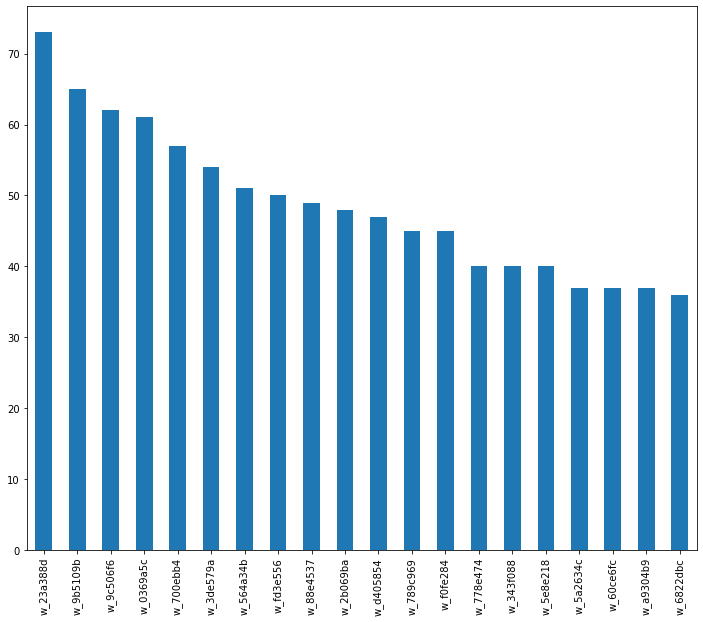

In [9]:
#Диаграмма количества китов , без new_whale    
train['Id'].value_counts()[1:21].plot(kind='bar')

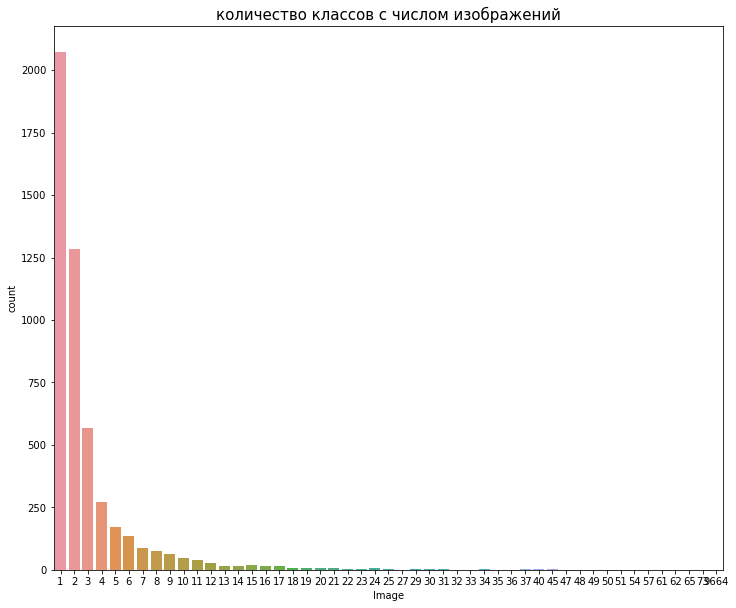

In [10]:
# частота классов по количеству фотографий китов
Group_by_Id = train.groupby("Id").count()
plt.figure()
sns.countplot(data=Group_by_Id, x="Image")
plt.title("количество классов с числом изображений",fontsize=15)
plt.show()

In [11]:
print("Min examples: ",Group_by_Id['Image'].min())
print("0.90 quantile: ",Group_by_Id['Image'].quantile(0.9))
print("0.99 quantile: ",Group_by_Id['Image'].quantile(0.99))


Min examples:  1
0.90 quantile:  6.0
0.99 quantile:  22.0


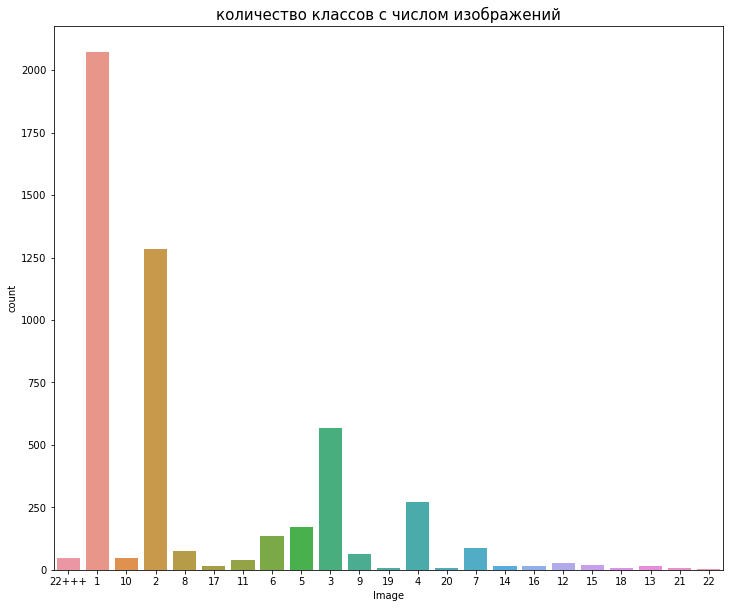

In [12]:
ddata = Group_by_Id.copy()
ddata.loc[ddata.Image > 22] = '22+++'
sns.countplot(ddata.Image.astype('str'))
plt.title("количество классов с числом изображений",fontsize=15)
plt.show()

В целом можно сделать следующие выводы:

общее число классов - 5005

2000+ китов имеют только одно изображение

самое большое количество изображений одного кита - 73

для 90% китов не более 6-и изображений каждого

больше всего изображени неизвестных китов : 9664


Примеры изображений китов

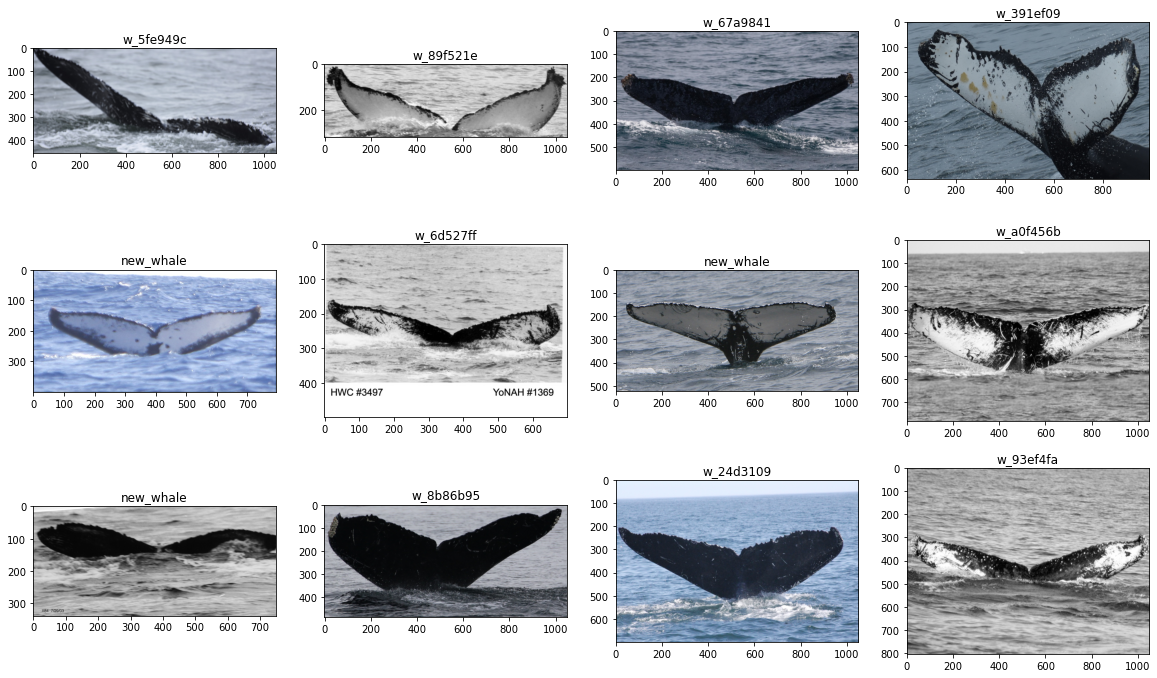

In [13]:
def display_samples(df, columns=4, rows=3 , path=TRAIN_D, offset=10):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_name = df.loc[offset+i,'Image']
        image_id = df.loc[offset+i,'Id']
        img = cv2.imread(path+str(image_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)

display_samples(train ,offset=588)

Вспомогательные процедуры

In [14]:
# преобразование данных для целевой метки
def prepare_labels(y):  
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    N= len(label_encoder.classes_)
    return integer_encoded, N,  label_encoder

In [15]:
y,N,label_encoder = prepare_labels(train['Id'])

In [16]:
print('число классов', N)
print(y)

число классов 5005
[4786 3808  662 ... 3671 3103    0]


In [17]:
# определим метрику top_k_categorical_accuracy
def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

Создадим базовую модель , с помощью которой прорвоедем эксперименты:сеть , в которой несколько групп сверточных словев.

Функцией потерь будет categorical_crossentropy , поскольку решается задача многоклассовой классификации. 

In [ ]:
# модель

def model_1(input_shape_=(112,112,3) , N=5005):
    model = Sequential()
  
    model.add(Conv2D(filters = 16, kernel_size = (5,5), padding = 'Same', 
                     activation = 'relu', input_shape = input_shape_))
    model.add(Conv2D(filters = 16, kernel_size = (5,5), padding = 'Same', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size = (2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size = (2,2), strides=(2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
    model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
    model.add(MaxPool2D(pool_size = (2,2), strides=(2,2)))
    model.add(Dropout(0.2))


    
    
    model.add(Flatten())
    model.add(Dense(256, activation="relu", name='rl'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Dense(N, activation='softmax', name='sm'))
    
    optimizer = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=[top_5_accuracy ,'accuracy'])
    return model

Создадим генераторы данных для использования

In [18]:
# Списки генераторов 
train_data_gen_list = []
train_generator_list = []
valid_generator_list = []


Генераторы и аугментация

In [19]:
# 0 base data Generator
train_data_gen = ImageDataGenerator(rescale=1/255.,
                                    preprocessing_function=imagenet_utils.preprocess_input,
                                    validation_split=0.12)
test_data_gen = ImageDataGenerator(rescale=1/255.,preprocessing_function=imagenet_utils.preprocess_input)


train_data_gen_list.append(train_data_gen)


# 1 flip

train_data_gen = ImageDataGenerator(rescale=1/255.,
                                    preprocessing_function=imagenet_utils.preprocess_input,
                                    horizontal_flip=True,
                                    validation_split=0.12)

train_data_gen_list.append(train_data_gen)


# 2 rotation

train_data_gen = ImageDataGenerator(rescale=1/255.,
                                    preprocessing_function=imagenet_utils.preprocess_input,
                                    rotation_range=20,
                                    validation_split=0.12)
train_data_gen_list.append(train_data_gen)

# 3 wshift

train_data_gen = ImageDataGenerator(rescale=1/255.,
                                    preprocessing_function=imagenet_utils.preprocess_input,
                                    width_shift_range=.1,
                                    validation_split=0.12)
train_data_gen_list.append(train_data_gen)


# 4 hshift

train_data_gen = ImageDataGenerator(rescale=1/255.,
                                    preprocessing_function=imagenet_utils.preprocess_input,
                                    height_shift_range=.1,
                                    validation_split=0.12)
train_data_gen_list.append(train_data_gen)

# 5 brightness

train_data_gen = ImageDataGenerator(rescale=1/255.,
                                    preprocessing_function=imagenet_utils.preprocess_input,
                                    brightness_range=(0.8,1.2),
                                    validation_split=0.12)
train_data_gen_list.append(train_data_gen)


# 6 shear

train_data_gen = ImageDataGenerator(rescale=1/255.,
                                    preprocessing_function=imagenet_utils.preprocess_input,
                                    shear_range=10,
                                    validation_split=0.12)
train_data_gen_list.append(train_data_gen)

# 7 zoom

train_data_gen = ImageDataGenerator(rescale=1/255.,
                                    preprocessing_function=imagenet_utils.preprocess_input,
                                    zoom_range=0.2,
                                    validation_split=0.12)
train_data_gen_list.append(train_data_gen)

# 8 all

train_data_gen = ImageDataGenerator(rescale=1/255.,
                                    preprocessing_function=imagenet_utils.preprocess_input,
                                    zoom_range=0.2,
                                    shear_range=10,
                                    brightness_range=(0.8,1.2),
                                    height_shift_range=.1,
                                    width_shift_range=.1,
                                    rotation_range=20,
                                    horizontal_flip=True,
                                    validation_split=0.12)
train_data_gen_list.append(train_data_gen)

In [20]:
train_data_gen_list

In [21]:
test_generator = test_data_gen.flow_from_dataframe(
    dataframe=submission_df,
    directory=TEST_D,
    x_col='Image',
    y_col=None,
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode=None,
    target_size=(112, 112)
)



for g in train_data_gen_list:
    train_generator = g.flow_from_dataframe(
        dataframe=train,
        directory=TRAIN_D,
        x_col='Image',
        y_col='Id',
        shuffle=True,
        subset="training",
        batch_size=32,
        seed=42,
        class_mode="categorical",
        target_size=(112, 112)
    )

    valid_generator = g.flow_from_dataframe(
        dataframe=train,
        directory=TRAIN_D,
        x_col='Image',
        y_col='Id',
        shuffle=False,
        subset="validation",
        batch_size=32,
        seed=42,
        class_mode="categorical",
        target_size=(112, 112)
    )

    train_generator_list.append(train_generator)
    valid_generator_list.append(valid_generator)









Found 7960 validated image filenames.
Found 22318 validated image filenames belonging to 5005 classes.
Found 3043 validated image filenames belonging to 5005 classes.
Found 22318 validated image filenames belonging to 5005 classes.
Found 3043 validated image filenames belonging to 5005 classes.
Found 22318 validated image filenames belonging to 5005 classes.
Found 3043 validated image filenames belonging to 5005 classes.
Found 22318 validated image filenames belonging to 5005 classes.
Found 3043 validated image filenames belonging to 5005 classes.
Found 22318 validated image filenames belonging to 5005 classes.
Found 3043 validated image filenames belonging to 5005 classes.
Found 22318 validated image filenames belonging to 5005 classes.
Found 3043 validated image filenames belonging to 5005 classes.
Found 22318 validated image filenames belonging to 5005 classes.
Found 3043 validated image filenames belonging to 5005 classes.
Found 22318 validated image filenames belonging to 5005 cla

Вспомогательная функция для конвертации полученных выходов сети в изначальные классы

In [ ]:
def _get_lmap(gen):
    return dict((v,k) for k,v in gen.class_indices.items())

In [ ]:
checkpoint_filepath = '/tmp/checkpoint'

Секция обучения моделей 

In [ ]:
for j in [0,1,2,3,4,5,6,7,8]:
    print(j)
    simp_mod= model_1()
    trg = train_generator_list[j]
    vg  = valid_generator_list[j]

    trg.reset()
    vg.reset()
    
    STEP_SIZE_TRAIN=trg.n//trg.batch_size
    STEP_SIZE_VALID=vg.n//vg.batch_size
    STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

    print('STEP_SIZE_TRAIN:',STEP_SIZE_TRAIN)
    print('STEP_SIZE_VALID:',STEP_SIZE_VALID)
    print('STEP_SIZE_TEST:',STEP_SIZE_TEST)
    
    

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_top_5_accuracy',
    mode='max',
    save_best_only=True)


    print('train')
    history= simp_mod.fit_generator(generator=trg,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=vg,
                    validation_steps=STEP_SIZE_VALID, use_multiprocessing=True,
                    workers=6 ,
                    epochs=12 ,verbose=1 ,callbacks=[model_checkpoint_callback])

    simp_mod.load_weights(checkpoint_filepath)
    
       
    label_map = _get_lmap(trg)
    
    col = ['Image']
    test_data = pd.DataFrame(submission_df['Image'], columns=col)
    test_data['Id'] = ''
    test_generator.reset()
    print('predict')
    predictions=simp_mod.predict_generator(test_generator, steps=STEP_SIZE_TEST, verbose=1)
    for i, pred in enumerate(predictions):
        lst =[label_map[ind] for ind in pred.argsort()[-5:][::-1]]
        test_data.loc[i, 'Id'] = ' '.join(lst)
        
    test_data.to_csv('submission_aug_ex_'+str(j)+'_.csv', index=False)

Посмотрим результаты, качество на платформе kaggle.  Измеряется метрика Mean Average Precision @ 5 (MAP@5).

In [22]:
Results = pd.DataFrame()
Results

""


In [23]:
Results['Public'] = [0.29988 , 0.32190 , 0.32032, 0.28817 ,0.29859 ,0.29909 ,0.31001 ,0.29903 ,0.28798]
Results['Private'] = [0.31408 , 0.33527 , 0.33485 , 0.29693 , 0.32174 ,0.31747 ,0.32550 ,0.31604 ,0.30465]
Results['Comment'] =['Base Gen' , 'Flip Gen' , 'Rotation Gen' , 'Width shift Gen' , 'Height shift Gen' , 'Brightness Gen' ,
                   'Shear Gen' , 'Zoom Gen' , 'All Gen']

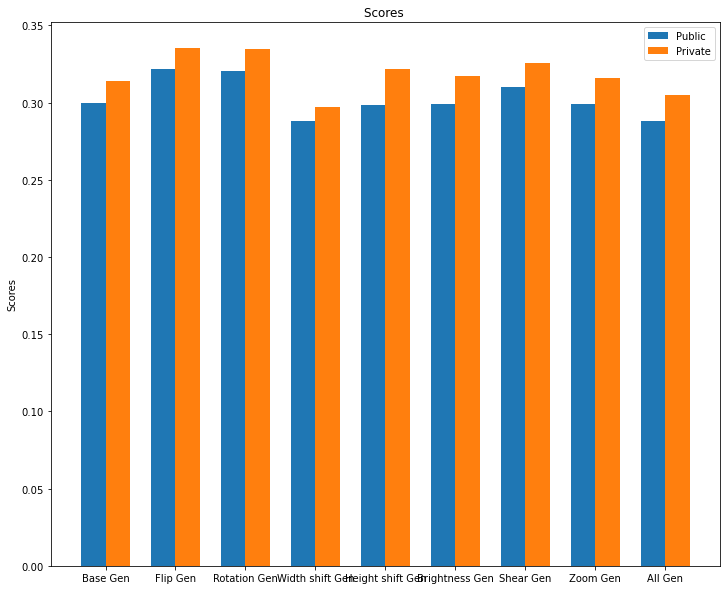

In [24]:
ind = np.arange(len(Results['Public']))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, Results['Public'], width, 
                label='Public')
rects2 = ax.bar(ind + width/2, Results['Private'], width, 
                label='Private')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores ')
ax.set_xticks(ind)
ax.set_xticklabels(Results['Comment'])
ax.legend()

Лучшая точность на данной сети достигается при операциях  отражения и небольшого вращения изображений 

На следующей этапе работ , обробуем операцию образки лишних параметров сети и посмотрим как изменится точность после данной операции 

Загружаем необходимые библиотеки

In [ ]:
!pip install -q tensorflow-model-optimization

In [ ]:
simp_mod= model_1()

simp_mod.load_weights(checkpoint_filepath)

In [ ]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

In [ ]:
num_images = 697
end_step = np.ceil(num_images / 32).astype(np.int32) * 12
print(end_step)

In [ ]:
# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

In [ ]:
model_for_pruning = prune_low_magnitude(simp_mod, **pruning_params)

In [ ]:
# `prune_low_magnitude` requires a recompile.
optimizer = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)
model_for_pruning.compile(loss='categorical_crossentropy', 
                          optimizer=optimizer, metrics=[top_5_accuracy ,'accuracy'])

model_for_pruning.summary()

In [ ]:
trg = train_generator_list[8]
vg  = valid_generator_list[8]

trg.reset()
vg.reset()
    
STEP_SIZE_TRAIN=trg.n//trg.batch_size
STEP_SIZE_VALID=vg.n//vg.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

print('STEP_SIZE_TRAIN:',STEP_SIZE_TRAIN)
print('STEP_SIZE_VALID:',STEP_SIZE_VALID)
print('STEP_SIZE_TEST:',STEP_SIZE_TEST)

In [ ]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_top_5_accuracy',
    mode='max',
    save_best_only=True)

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  model_checkpoint_callback,
]
  
model_for_pruning.fit_generator(generator=trg,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=vg,
                    validation_steps=STEP_SIZE_VALID, use_multiprocessing=True,
                    workers=6 ,
                    epochs=12 ,verbose=1 ,callbacks=callbacks)

In [ ]:
for i, w in enumerate(model_for_pruning.get_weights()):
    print(
        "{} -- Total:{}, Zeros: {:.2f}%".format(
            model_for_pruning.weights[i].name, w.size, np.sum(w == 0) / w.size * 100
        )
    )

In [ ]:
label_map = _get_lmap(trg)
    
col = ['Image']
test_data = pd.DataFrame(submission_df['Image'], columns=col)
test_data['Id'] = ''
test_generator.reset()
print('predict')
predictions=model_for_pruning.predict_generator(test_generator, steps=STEP_SIZE_TEST, verbose=1)
for i, pred in enumerate(predictions):
    lst =[label_map[ind] for ind in pred.argsort()[-5:][::-1]]
    test_data.loc[i, 'Id'] = ' '.join(lst)
        
test_data.to_csv('submission_apruning_.csv', index=False)

Точность  на лидерборде составила Private 0.29210 , public 0.27766

In [25]:
new_row = {'Public':0.27766, 'Private':0.29210, 'Comment':'Prunung for All Gen'}
#append row to the dataframe
Results = Results.append(new_row, ignore_index=True)


Уменьшение точности в % относительно такой же модели и данных . обученных ранее

In [27]:
print ( 'Уменьшение точности =',round((Results.loc[8,'Private'] - Results.loc[9,'Private'])*100.0/Results.loc[9,'Private']), '%')

Уменьшение точности = 4.0 %


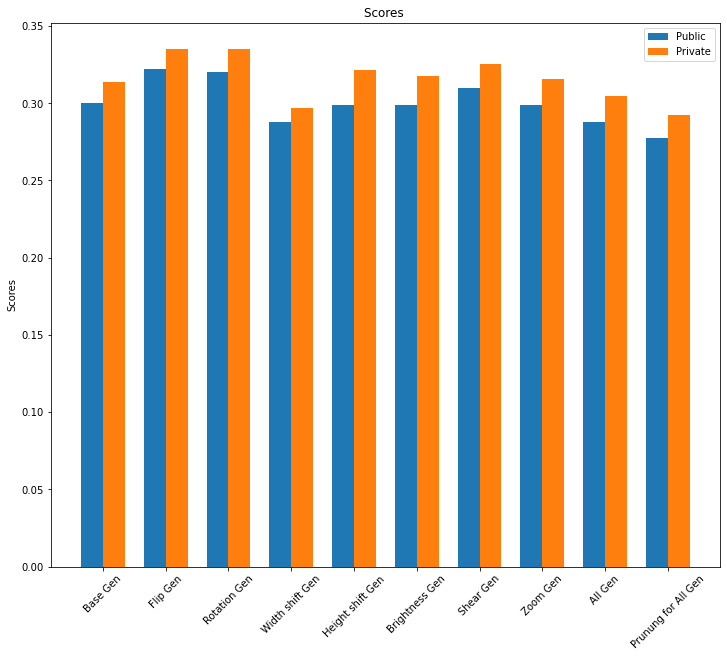

In [29]:
ind = np.arange(len(Results['Public']))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, Results['Public'], width, 
                label='Public')
rects2 = ax.bar(ind + width/2, Results['Private'], width, 
                label='Private')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores ')
ax.set_xticks(ind)
ax.set_xticklabels(Results['Comment'] ,rotation=45 )
#ax.set_xticklabels(Results['Comment'])
ax.legend()

На следующем этапе экспериментов , Опробуем операцию Knowledge distillation 

Ссылка на описание и примеры https://keras.io/examples/vision/knowledge_distillation/

In [ ]:
# исходная модель , выделен слойс logits
def model_2(input_shape_=(112,112,3) , N=5005):
    model = Sequential()
  
    model.add(Conv2D(filters = 16, kernel_size = (5,5), padding = 'Same', 
                     activation = 'relu', input_shape = input_shape_))
    model.add(Conv2D(filters = 16, kernel_size = (5,5), padding = 'Same', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size = (2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size = (2,2), strides=(2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
    model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
    model.add(MaxPool2D(pool_size = (2,2), strides=(2,2)))
    model.add(Dropout(0.2))

  
    
    model.add(Flatten())
    model.add(Dense(256, activation="relu", name='rl'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Dense(N, name='logits'))
    model.add(Activation('softmax'))
    
    optimizer = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)
    
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=[top_5_accuracy ,'accuracy'])
    return model

In [ ]:
t_mod= model_2()

In [ ]:
checkpoint_filepath = '/tmp/checkpoint'

for j in [8]:
    print(j)
    trg = train_generator_list[j]
    vg  = valid_generator_list[j]

    trg.reset()
    vg.reset()
    
    STEP_SIZE_TRAIN=trg.n//trg.batch_size
    STEP_SIZE_VALID=vg.n//vg.batch_size
    STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

    print('STEP_SIZE_TRAIN:',STEP_SIZE_TRAIN)
    print('STEP_SIZE_VALID:',STEP_SIZE_VALID)
    print('STEP_SIZE_TEST:',STEP_SIZE_TEST)
    
    

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_top_5_accuracy',
    mode='max',
    save_best_only=True)


    print('train')
    history= t_mod.fit_generator(generator=trg,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=vg,
                    validation_steps=STEP_SIZE_VALID, use_multiprocessing=True,
                    workers=6 ,
                    epochs=12 ,verbose=1 ,callbacks=[model_checkpoint_callback])

    t_mod.load_weights(checkpoint_filepath)
    

Создадим вспомогательный класс  Distiller.


In [ ]:
class Distiller(tf.keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.

        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        
        x, y = data
        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)
        
        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)

            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
        
        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Compute predictions
        y_prediction = self.student(x, training=False)

        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

    def call(self, inputs):
        return self.student(inputs)

Создадим модель студент, с меньшим количеством сверточных каналов, те сменьшей по параметрам сетью, архитектура сети проще исходной

In [ ]:
def model_3(input_shape_=(112,112,3) , N=5005):
    model = Sequential()
  
    model.add(Conv2D(filters = 8, kernel_size = (5,5), padding = 'Same', 
                     activation = 'relu', input_shape = input_shape_))
    model.add(Conv2D(filters = 8, kernel_size = (5,5), padding = 'Same', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size = (2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters = 16, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
    model.add(Conv2D(filters = 16, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size = (2,2), strides=(2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
    model.add(MaxPool2D(pool_size = (2,2), strides=(2,2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(256, activation="relu", name='rl'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Dense(N, name='logits'))
    #model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=[top_5_accuracy ,'accuracy'])
    return model

In [ ]:
s_mod = model_3()

In [ ]:
teacher = tf.keras.Model(inputs=t_mod.input, outputs = t_mod.get_layer('logits').output)
teacher.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
teacher.summary()

In [ ]:
distiller = Distiller(student=s_mod, teacher=teacher)
distiller.compile(
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.CategoricalCrossentropy(from_logits=True) , top_5_accuracy],
    student_loss_fn=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    distillation_loss_fn=tf.keras.losses.KLDivergence(),
    alpha=0.1,
    temperature=10,
)

проводим обучение

In [ ]:
checkpoint_filepath = '/tmp/checkpoint'
for j in [8]:
    print(j)
    trg = train_generator_list[j]
    vg  = valid_generator_list[j]

    trg.reset()
    vg.reset()
    
    STEP_SIZE_TRAIN=trg.n//trg.batch_size
    STEP_SIZE_VALID=vg.n//vg.batch_size
    STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

    print('STEP_SIZE_TRAIN:',STEP_SIZE_TRAIN)
    print('STEP_SIZE_VALID:',STEP_SIZE_VALID)
    print('STEP_SIZE_TEST:',STEP_SIZE_TEST)
    
    

    print('train')
    history= distiller.fit_generator(generator=trg,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=vg,
                    validation_steps=STEP_SIZE_VALID, use_multiprocessing=True,
                    workers=6 ,
                    epochs=12 ,verbose=1 )
    
       
    label_map = _get_lmap(trg)
    
    col = ['Image']
    test_data = pd.DataFrame(submission_df['Image'], columns=col)
    test_data['Id'] = ''
    test_generator.reset()
    print('predict')
    predictions=distiller.predict_generator(test_generator, steps=STEP_SIZE_TEST, verbose=1)
    for i, pred in enumerate(predictions):
        lst =[label_map[ind] for ind in pred.argsort()[-5:][::-1]]
        test_data.loc[i, 'Id'] = ' '.join(lst)
        
    test_data.to_csv('submission_aug_distiller.csv', index=False)

In [30]:
new_row = {'Public':0.29348, 'Private':0.31022, 'Comment':'Knowledge Distillation All Gen'}
#append row to the dataframe
Results = Results.append(new_row, ignore_index=True)

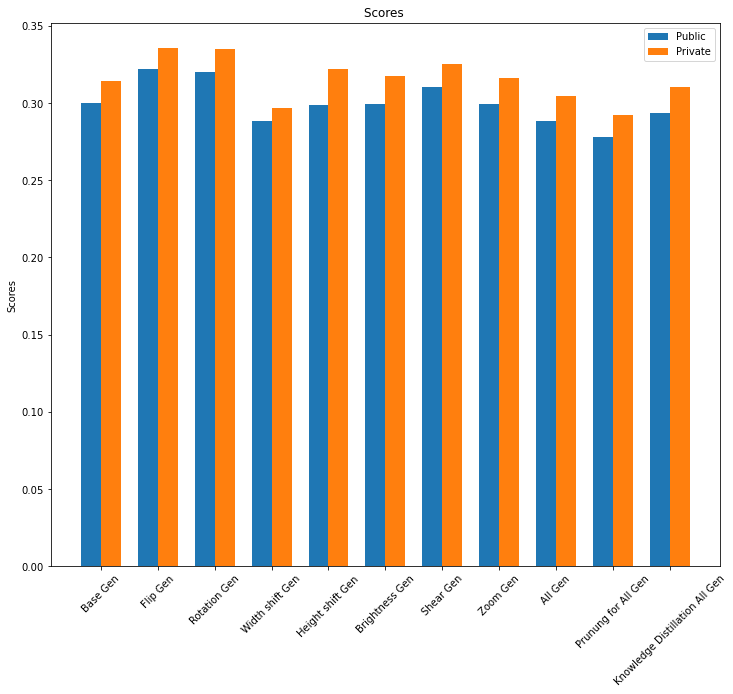

In [32]:
ind = np.arange(len(Results['Public']))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, Results['Public'], width, 
                label='Public')
rects2 = ax.bar(ind + width/2, Results['Private'], width, 
                label='Private')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores ')
ax.set_xticks(ind)
ax.set_xticklabels(Results['Comment'] ,rotation=45 )
ax.legend()

Стоит заметить, что удалось несколько повысить точность 

Для демонстрации операции, обучем отдельно сеть с параметрами сети `студент` по классической схеме. И покажем что точность кардинально меньше.

In [ ]:
s2_mod = model_3()
optimizer = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)
s2_mod.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=[top_5_accuracy ,'accuracy'])

In [ ]:
checkpoint_filepath = '/tmp/checkpoint'
for j in [8]:
    print(j)
    trg = train_generator_list[j]
    vg  = valid_generator_list[j]

    trg.reset()
    vg.reset()
    
    STEP_SIZE_TRAIN=trg.n//trg.batch_size
    STEP_SIZE_VALID=vg.n//vg.batch_size
    STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

    print('STEP_SIZE_TRAIN:',STEP_SIZE_TRAIN)
    print('STEP_SIZE_VALID:',STEP_SIZE_VALID)
    print('STEP_SIZE_TEST:',STEP_SIZE_TEST)
    
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_top_5_accuracy',
    mode='max',
    save_best_only=True)


    print('train')
    history= s2_mod.fit_generator(generator=trg,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=vg,
                    validation_steps=STEP_SIZE_VALID, use_multiprocessing=True,
                    workers=6 ,
                    epochs=12 ,verbose=1 ,callbacks=[model_checkpoint_callback])

    s2_mod.load_weights(checkpoint_filepath)
    
       
    label_map = _get_lmap(trg)
    
    col = ['Image']
    test_data = pd.DataFrame(submission_df['Image'], columns=col)
    test_data['Id'] = ''
    test_generator.reset()
    print('predict')
    predictions=s2_mod.predict_generator(test_generator, steps=STEP_SIZE_TEST, verbose=1)
    for i, pred in enumerate(predictions):
        lst =[label_map[ind] for ind in pred.argsort()[-5:][::-1]]
        test_data.loc[i, 'Id'] = ' '.join(lst)
        
    test_data.to_csv('submission_aug_student.csv', index=False)

In [33]:
new_row = {'Public':0.21770, 'Private':0.21134, 'Comment':'Student model All Gen'}
#append row to the dataframe
Results = Results.append(new_row, ignore_index=True)

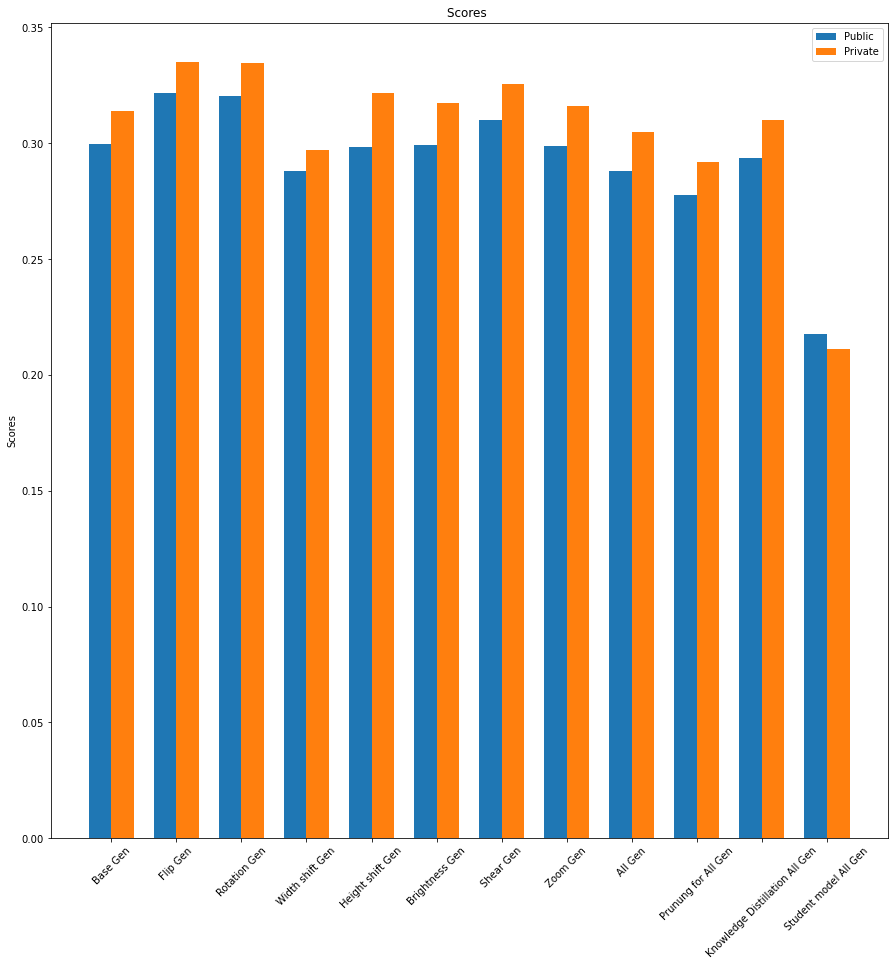

In [34]:
ind = np.arange(len(Results['Public']))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(15,15))

rects1 = ax.bar(ind - width/2, Results['Public'], width, 
                label='Public')
rects2 = ax.bar(ind + width/2, Results['Private'], width, 
                label='Private')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores ')
ax.set_xticks(ind)
ax.set_xticklabels(Results['Comment'] ,rotation=45 )
ax.legend()

Точность сети ниже, чем при обучении с помощью  подхода Knowledge distillation 